In [ ]:
import torch
print(torch.__version__)

2.5.1+cu121


In [ ]:
!python --version

Python 3.10.12


#**1. Setting up the Environment** </font>



In [ ]:
# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

  # Install the latest version of torchtext library quietly without showing output
  # !pip install torchtext -qq
  !pip install transformers evaluate wandb datasets accelerate peft bitsandbytes trl fsspec -U  -qq ## NEW LINES ##
  basepath = '/content/drive/MyDrive/'
else:
  basepath = '/content/drive/MyDrive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<font color = 'indianred'> *Load Libraries* </font>

In [ ]:
# standard pythgion libraries
from pathlib import Path
import re
import gc
import time
from typing import Dict, List, Union, Optional
from tqdm import tqdm
import itertools
import json
import joblib
import ast
from datetime import datetime
from difflib import get_close_matches

# Data Science librraies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score

# Pytorch
import torch
import torch.nn as nn

# Huggingface Librraies
import evaluate
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM
from transformers import (
    TrainingArguments,
    Trainer,
    set_seed,
    AutoTokenizer,
    AutoModelForCausalLM,
    DataCollatorForLanguageModeling,
    AutoConfig,
    pipeline,
    BitsAndBytesConfig,
)
from peft import (
    TaskType,
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model,
    AutoPeftModelForCausalLM,
    PeftConfig
)

from huggingface_hub import login

# Logging and secrets
import wandb
from google.colab import userdata


In [ ]:
set_seed(42)

In [ ]:
# Your actual tokens (use environment variables or leave empty by default)
wandb_api_key = os.getenv("WANDB_API_KEY", "")
hf_token = os.getenv("HF_TOKEN", "")

In [ ]:
if hf_token:
    # Log in to Hugging Face
    login(token=hf_token)
    print("Successfully logged in to Hugging Face!")
else:
    print("Hugging Face token not found in notebook secrets.")


Successfully logged in to Hugging Face!


In [ ]:
if wandb_api_key:
  wandb.login(key=wandb_api_key)
  print("Successfully logged in to WANDB!")
else:
    print("WANDB key not found in notebook secrets.")


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: naikgautam234 (naikgautam234-university-of-texas-dallas). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Successfully logged in to WANDB!


In [ ]:
base_folder = Path(basepath)
data_folder = base_folder/"Data"
model_folder = base_folder/'models'
custom_functions = base_folder / "custom_files"

In [ ]:
model_folder.mkdir(exist_ok=True, parents = True)

In [ ]:
train_data_path = data_folder / "train.csv"
test_data_path = data_folder / "test.csv"

In [ ]:
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

In [ ]:
train_data.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


In [ ]:
test_data.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-01559,@Adnan__786__ @AsYouNotWish Dont worry Indian ...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
1,2018-03739,"Academy of Sciences, eschews the normally sobe...",NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
2,2018-00385,I blew that opportunity -__- #mad,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
3,2018-03001,This time in 2 weeks I will be 30... 😥,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
4,2018-01988,#Deppression is real. Partners w/ #depressed p...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE


In [ ]:
class_names = [col for col in train_data.columns if col not in ['Tweet','ID']]
class_names

['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'love',
 'optimism',
 'pessimism',
 'sadness',
 'surprise',
 'trust']

In [ ]:
def transform_labels_in_dataframe(df, class_columns):
    """
    Transforms binary class columns into label names and compiles non-empty labels into a list.

    Args:
        df (DataFrame): The input DataFrame containing binary class columns.
        class_columns (list): List of column names representing classes.

    Returns:
        DataFrame: Updated DataFrame with transformed columns and a new 'label' column.
    """
    for column_name in class_columns:
        df[column_name] = df[column_name].apply(lambda x: column_name if x == 1 else None if x == 0 else x)
    df['label'] = df[class_columns].apply(lambda row: [col for col, val in zip(class_columns, row) if val is not None], axis=1)
    return df

# Example usage:
# Assuming your DataFrame is named 'train_data' and 'class_columns' is your list of columns
df = transform_labels_in_dataframe(train_data, class_names)

In [ ]:
df.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,label
0,2017-21441,“Worry is a down payment on a problem you may ...,None,anticipation,None,None,None,None,optimism,None,None,None,trust,"[anticipation, optimism, trust]"
1,2017-31535,Whatever you decide to do make sure it makes y...,None,None,None,None,joy,love,optimism,None,None,None,None,"[joy, love, optimism]"
2,2017-21068,@Max_Kellerman it also helps that the majorit...,anger,None,disgust,None,joy,None,optimism,None,None,None,None,"[anger, disgust, joy, optimism]"
3,2017-31436,Accept the challenges so that you can literall...,None,None,None,None,joy,None,optimism,None,None,None,None,"[joy, optimism]"
4,2017-22195,My roommate: it's okay that we can't spell bec...,anger,None,disgust,None,None,None,None,None,None,None,None,"[anger, disgust]"


In [ ]:
train_val = Dataset.from_dict({
    'text': df['Tweet'],
    'label': df['label'],  # Use the modified 'label' column directly
}).train_test_split(test_size=0.35, shuffle=True)
train_val['valid'] = train_val.pop('test')

In [ ]:
train_val['train']['label'][0]

['anger', 'disgust']

In [ ]:
train_val

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 5020
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 2704
    })
})

In [ ]:
test_set= Dataset.from_dict({
    'text': test_data['Tweet'],
    'label': test_data[class_names].values.tolist(),
    })

In [ ]:
test_set

Dataset({
    features: ['text', 'label'],
    num_rows: 3259
})

#**4. Load pre-trained Tokenizer**</font>



In [ ]:
def free_gpu_memory():
    """
    Frees up GPU memory after CUDA out-of-memory error in Colab.

    This function performs the following steps:
    1. Deletes all PyTorch objects to clear references.
    2. Calls garbage collection to remove unreferenced objects from memory.
    3. Uses torch.cuda.empty_cache() to release cached GPU memory.
    4. Waits for a moment to ensure memory is fully released.
    """
    try:
        # Delete all torch tensors to free up memory
        for obj in list(locals().values()):
            if torch.is_tensor(obj):
                del obj

        # Collect garbage to release any remaining unused memory
        gc.collect()

        # Empty the CUDA cache to release GPU memory
        torch.cuda.empty_cache()

        # Adding a small delay to allow memory to be fully released
        time.sleep(2)

        print("GPU memory has been freed.")
    except Exception as e:
        print(f"Error while freeing GPU memory: {e}")


In [ ]:
free_gpu_memory()

GPU memory has been freed.


In [ ]:
checkpoint = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
tokenizer.eos_token


'<|end_of_text|>'

In [ ]:
tokenizer.pad_token

In [ ]:
tokenizer.pad_token = "<|finetune_right_pad_id|>"

In [ ]:
tokenizer.special_tokens_map

{'bos_token': '<|begin_of_text|>',
 'eos_token': '<|end_of_text|>',
 'pad_token': '<|finetune_right_pad_id|>'}

In [ ]:
tokenizer.chat_template

#**5. Create Prompts**



In [ ]:
def format_examples_as_prompts(examples, input_field, output_field, prompt_template, output_delimiter, tokenizer, include_eos_token=True):
    """
    Format a single example or batch of examples for prompt generation.

    Args:
        examples (Union[dict, LazyRow]): Input examples, either as a single dict or batch of examples.
        input_field (str): Key for the input text in the examples.
        output_field (str): Key for the output text in the examples.
        prompt_template (str): Template string with placeholders for formatting the prompts.
        output_delimiter (str): Delimiter to separate input and output in the prompt.
        tokenizer: Tokenizer object, used to append an EOS token if required.
        include_eos_token (bool): Whether to include the EOS token at the end of each prompt.

    Returns:
        Union[str, List[str]]: Formatted prompt(s) as a string or list of strings.
    """
    # Convert LazyRow to dictionary if applicable
    if hasattr(examples, 'keys'):
        examples = dict(examples)

    # Handle single example (dictionary input)
    if isinstance(examples, dict):
        # Check if the input field contains a single example or a batch
        if not isinstance(examples[input_field], (list, tuple)):
            # Process single example
            input_text = examples[input_field].strip()
            output_text = examples[output_field]
            output_delimiter = output_delimiter.strip()

            # Generate the prompt using the template
            prompt = prompt_template.format(input_text, output_delimiter, output_text)

            # Append EOS token if required
            if include_eos_token:
                prompt = prompt + tokenizer.eos_token

            return prompt.strip()
        else:
            # Process batch of examples
            formatted_prompts = []
            for i in range(len(examples[input_field])):
                input_text = examples[input_field][i].strip()
                output_text = examples[output_field][i]
                output_delimiter = output_delimiter.strip()

                # Generate the prompt for each example
                prompt = prompt_template.format(input_text, output_delimiter, output_text)

                # Append EOS token if required
                if include_eos_token:
                    prompt = prompt + tokenizer.eos_token

                formatted_prompts.append(prompt.strip())

            return formatted_prompts

    # Raise an error for unexpected input formats
    print("Unexpected input format!")
    print("Type:", type(examples))
    print("Content:", examples)
    raise ValueError(f"Expected a dictionary or LazyRow with examples, got {type(examples)}")

In [ ]:
prompt_template = 'Classify the TEXT by selecting all applicable labels from the following list: \
["anger", "anticipation", "disgust", "fear", "joy", "love", "optimism", "pessimism", "sadness", "surprise","trust"].\
 ### TEXT: {} {} {}'

In [ ]:
output_delimiter = "### LABEL:"
input_field = 'text'
output_field = 'label'

In [ ]:
output_delimiter

'### LABEL:'

In [ ]:
from functools import partial

In [ ]:
formatting_prompts_func_final = partial(format_examples_as_prompts,
                                        input_field =input_field,
                                        output_field = output_field,
                                        prompt_template=prompt_template,
                                        output_delimiter=output_delimiter,
                                        tokenizer=tokenizer
)

In [ ]:
train_val['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 5020
})

In [ ]:
samples = formatting_prompts_func_final(train_val['train'][0:3])

In [ ]:
from pprint import pprint
pprint(samples[2], width=120)

('Classify the TEXT by selecting all applicable labels from the following list: ["anger", "anticipation", "disgust", '
 '"fear", "joy", "love", "optimism", "pessimism", "sadness", "surprise","trust"]. ### TEXT: @MetsProspectHub '
 '@brianpmangan taking offense to acount...he ranks 32 of 36 over last 2 years by SABR ### LABEL: '
 "['anger']<|end_of_text|>")


In [ ]:
single_sample = formatting_prompts_func_final(train_val['train'][1])
pprint(single_sample, width=120)

('Classify the TEXT by selecting all applicable labels from the following list: ["anger", "anticipation", "disgust", '
 '"fear", "joy", "love", "optimism", "pessimism", "sadness", "surprise","trust"]. ### TEXT: I mean, not that I wanted '
 "goats to faint... but I wanted to see the goats faint.  #eclipse ### LABEL: ['joy', 'optimism', "
 "'sadness']<|end_of_text|>")


##**5.1 Filter Longer sequences**

In [ ]:
def filter_examples_by_length(example, max_length, tokenizer, prompt_function):
    """
    Filter a single example based on the total tokenized length of the generated prompt.

    Args:
        example (Union[dict, LazyRow]): A single input example to filter.
        max_length (int): Maximum allowed tokenized length.
        tokenizer: Tokenizer object to tokenize the prompt.
        prompt_function (Callable): Function to generate the prompt for the example.

    Returns:
        dict: The example with an added 'keep' field indicating if it meets the length requirement.
    """
    # Convert LazyRow to dictionary if applicable
    example_dict = dict(example) if hasattr(example, 'keys') else example

    # Generate the prompt using the provided function
    prompt = prompt_function(example_dict)

    # Tokenize the generated prompt
    tokenized_prompt = tokenizer(prompt, add_special_tokens=False, truncation=False, padding=False)
    total_length = len(tokenized_prompt['input_ids'])

    # Add a 'keep' field to indicate if the example passes the length filter
    example['keep'] = total_length <= max_length
    return example


# Create a partial function for filtering
filter_function = partial(
    filter_examples_by_length,
    max_length=1000,
    tokenizer=tokenizer,
    prompt_function=formatting_prompts_func_final
)

# Apply the filter function to the dataset
train_val_subset = train_val.map(filter_function, desc="Filtering dataset by length")

Filtering dataset by length:   0%|          | 0/5020 [00:00<?, ? examples/s]

Filtering dataset by length:   0%|          | 0/2704 [00:00<?, ? examples/s]

In [ ]:
train_val_subset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'keep'],
        num_rows: 5020
    })
    valid: Dataset({
        features: ['text', 'label', 'keep'],
        num_rows: 2704
    })
})

In [ ]:
train_val_subset_filtered = train_val_subset.filter(lambda x: x['keep']).remove_columns(['keep'])

Filter:   0%|          | 0/5020 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2704 [00:00<?, ? examples/s]

In [ ]:
train_val_subset_filtered

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 5020
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 2704
    })
})

##**5.2 Data Collator**

In [ ]:
def extract_token_ids_from_context(tokenizer, full_text, target_substring):
    """
    Extract the token IDs corresponding to a substring within a full text,
    including one token before the start of the substring for context.

    Args:
        tokenizer: The tokenizer object used for encoding.
        full_text (str): The full string containing the substring.
        target_substring (str): The substring for which token IDs are to be extracted.

    Returns:
        List[int]: List of token IDs corresponding to the substring within context.
    """
    # Tokenize the full text
    full_token_ids = tokenizer.encode(full_text, add_special_tokens=False)

    # Determine the start and end positions of the target substring in the full text
    start_idx = full_text.index(target_substring)
    end_idx = start_idx + len(target_substring)

    # Identify token indices, including one token before the start index
    start_token_idx = max(0, len(tokenizer.encode(full_text[:start_idx], add_special_tokens=False)) - 1)
    end_token_idx = len(tokenizer.encode(full_text[:end_idx], add_special_tokens=False))

    # Extract and return the relevant token IDs
    return full_token_ids[start_token_idx:end_token_idx]

In [ ]:
# Create a sample prompt format
sample_prompt_format = "some text {} {} {}"

# Create a sample prompt
sample_prompt = sample_prompt_format.format("input", output_delimiter, "output")
sample_prompt

'some text input ### LABEL: output'

In [ ]:
output_delimiter_ids = extract_token_ids_from_context(tokenizer, full_text=sample_prompt, target_substring=output_delimiter )

# Print debug information
print('Original output_delimiter:', output_delimiter)
print('output_delimiter_ids:', output_delimiter_ids)
print('Delimiter tokens:', tokenizer.convert_ids_to_tokens(output_delimiter_ids))
print('Reconstructed output_delimiter:', tokenizer.decode(output_delimiter_ids))

Original output_delimiter: ### LABEL:
output_delimiter_ids: [17010, 57974, 25]
Delimiter tokens: ['Ġ###', 'ĠLABEL', ':']
Reconstructed output_delimiter:  ### LABEL:


In [ ]:
data_collator_comp = DataCollatorForCompletionOnlyLM(tokenizer=tokenizer, mlm=False,
                                                      response_template=output_delimiter_ids)

#**6. Model Training**

##**6.1 Download pre-trained model**

In [ ]:
def get_appropriate_dtype():
    if torch.cuda.is_available() and torch.cuda.get_device_capability(0) >= (8, 0):
        return torch.bfloat16
    return torch.float16

In [ ]:
torch_data_type = get_appropriate_dtype()
torch_data_type

torch.bfloat16

In [ ]:
bnb_config = BitsAndBytesConfig(
  load_in_4bit=True,
  bnb_4bit_quant_type="nf4",
  bnb_4bit_use_double_quant=True,
  bnb_4bit_compute_dtype=torch_data_type,
  bnb_4bit_quant_storage=torch_data_type,
)

In [ ]:
model = AutoModelForCausalLM.from_pretrained(checkpoint,
                                             quantization_config=bnb_config,
                                             torch_dtype=torch_data_type,
                                             trust_remote_code=True,)


`low_cpu_mem_usage` was None, now default to True since model is quantized.


##**6.2 PEFT Setup**

In [ ]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-0

In [ ]:
def find_linear_layers(model):
    """
    Extracts the unique names of Linear layers from a model.

    Args:
    model (nn.Module): The model from which to extract Linear layer names.

    Returns:
    list: A list of unique names of Linear layers.
    """
    # Convert the model's modules to string
    model_modules = str(model.modules)
    # Pattern to extract names of Linear layers
    pattern = r'\((\w+)\): Linear'
    # Find all occurrences of the pattern
    linear_layer_names = re.findall(pattern, model_modules)
    print(linear_layer_names)
    # Get unique names using a set, then convert back to list
    target_modules = list(set(linear_layer_names))
    return target_modules

In [ ]:
find_linear_layers(model)

['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj', 'lm_head']


['gate_proj',
 'k_proj',
 'down_proj',
 'q_proj',
 'o_proj',
 'lm_head',
 'up_proj',
 'v_proj']

In [ ]:
TaskType.CAUSAL_LM

<TaskType.CAUSAL_LM: 'CAUSAL_LM'>

In [ ]:
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=128,
    lora_alpha=256,
    lora_dropout=0.01,
    target_modules = ['v_proj',  'q_proj',  'up_proj', 'o_proj', 'down_proj', 'gate_proj','k_proj'])

lora_model = get_peft_model(model, peft_config )
# qlora_model.resize_token_embeddings(len(tokenizer))
lora_model.print_trainable_parameters()

trainable params: 90,177,536 || all params: 1,325,991,936 || trainable%: 6.8008


##**6.3 Training Arguments**</font>







In [ ]:
# Define the directory where model checkpoints will be saved
model_folder = base_folder/'models/llama_qlora_lmh'

# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)
run_name= 'stack_exp_lmh_llama'

use_fp16 = torch_data_type == torch.float16
use_bf16 = torch_data_type == torch.bfloat16

# Configure training parameters
training_args = SFTConfig(
    seed = 42,
    # Training-specific configurations
    num_train_epochs=2,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant":False},
    # torch_empty_cache_steps=5,
    weight_decay=0.0,  # Apply L2 regularization to prevent overfitting
    learning_rate=1e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    output_dir=str(model_folder),
    eval_strategy='steps',
    eval_steps=20,
    save_strategy="steps",
    save_steps=20,
    load_best_model_at_end=True,
    save_total_limit=2,
    metric_for_best_model="eval_loss",
    greater_is_better=False,


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',
    run_name= run_name,

    fp16=use_fp16 ,
    bf16=use_bf16,
    tf32=False,
)


In [ ]:
# If gradient checkpointing is enabled, configure relevant settings
if training_args.gradient_checkpointing:
    model.config.use_cache = False  # Disable caching for compatibility

model.config

LlamaConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "meta-llama/Llama-3.2-1B",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128001,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_storage": "bfloat16",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_4bit": true,
    "load_in_8

##**6.4 Initialize Trainer**</font>



In [ ]:
trainer = SFTTrainer(
        model=model,
        tokenizer=tokenizer,
        args=training_args,
        train_dataset=train_val_subset_filtered['train'],
        eval_dataset=train_val_subset_filtered['valid'],
        peft_config=peft_config,
        formatting_func =  formatting_prompts_func_final,
        data_collator=data_collator_comp,)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:309: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/5020 [00:00<?, ? examples/s]

Map:   0%|          | 0/2704 [00:00<?, ? examples/s]

## <font color = 'indianred'> **6.5 Setup WandB**</font>

In [ ]:
%env WANDB_PROJECT = multilabel_stack

env: WANDB_PROJECT=multilabel_stack


##  <font color = 'indianred'> **6.7 Training**

In [ ]:
try:
    trainer.train()
except RuntimeError as e:
    if 'CUDA out of memory' in str(e):
        print("CUDA out of memory error detected. Freeing GPU memory.")
        free_gpu_memory()
    else:
        raise e


Step,Training Loss,Validation Loss
20,0.660600,0.429194
40,0.392100,0.395368
60,0.378400,0.365093
80,0.359200,0.355094
100,0.350900,0.354388
120,0.335300,0.358069
140,0.331100,0.338763
160,0.331900,0.339606
180,0.303900,0.336845
200,0.311700,0.330611


In [ ]:
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]

In [ ]:
best_model_checkpoint_step

'300'

##**6.8 Validation**

<font color = 'indianred'> *Evaluate model on Validation Set* </font>


In [ ]:
model_folder = base_folder/'models/llama_qlora_lmh'
best_model_checkpoint_step
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
checkpoint

'/content/drive/MyDrive/NLP/models/llama_qlora_lmh/checkpoint-300'

In [ ]:
from peft import AutoPeftModelForCausalLM, PeftConfig

In [ ]:
model = AutoPeftModelForCausalLM.from_pretrained(checkpoint,
                                             quantization_config=bnb_config,
                                             torch_dtype=torch_data_type,
                                             trust_remote_code=True,
                                             device_map='auto')

In [ ]:
model.device

device(type='cuda', index=0)

In [ ]:
peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.pad_token = "<|finetune_right_pad_id|>"
tokenizer.padding_side='left'


In [ ]:
def execute_inference_pipeline(
    seed: int,
    dataset: Union[Dict, List],
    model,
    tokenizer,
    per_device_batch_size: int,
    prompt_template: str,
    input_field: str,
    output_field: str,
    output_delimiter: str,
    save_dir: Optional[Path] = None,
    save_file_name: Optional[str] = None,
    max_new_tokens: int = 10,
    num_beams: int = 1,
    do_sample: bool = False,
    top_k: int = 50,
    top_p: float = 1.0,
    temperature: float = 1.0,
    no_repeat_ngram_size: int = 2,
    num_return_sequences: int = 1
) -> List[Dict]:

    set_seed(seed)
    model.eval()
    print(f"Model device for inference: {model.device}")
    device = model.device
    batch_size = per_device_batch_size

    inference_results = []

    progress_bar = tqdm(range(0, len(dataset), batch_size), desc="Generating responses")

    for i in progress_bar:
        # Create a batch
        batch = dataset[i:i + batch_size]

        try:
            texts = batch[input_field]
            labels = batch[output_field] if output_field in batch else ["N/A"] * len(texts)
            prompts = [prompt_template.format(text.strip(), output_delimiter.strip(), "").strip() for text in texts]
            inputs = tokenizer(prompts, return_tensors="pt", padding=True)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=max_new_tokens,
                    num_beams=num_beams,
                    do_sample=do_sample,
                    top_k=top_k,
                    top_p=top_p,
                    temperature=temperature,
                    no_repeat_ngram_size=no_repeat_ngram_size,
                    num_return_sequences=num_return_sequences,
                    pad_token_id=tokenizer.pad_token_id,
                )

            decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)

            for text, label, decoded_output in zip(texts, labels, decoded_outputs):
                inference_results.append({
                    "input": text,
                    "generated_output": decoded_output,
                    "ground_truth": label
                })

            continue

        except Exception as e:
            print(f"Error processing batch: {str(e)}")
            print(f"Problematic batch: {batch}")
            continue

    # Save generations if path provided
    if save_dir:
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)

        # If no filename provided, create a timestamped one
        if save_file_name is None:
            from datetime import datetime
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            save_name = f"generations_{timestamp}.json"
        elif not save_file_name.endswith('.json'):
            save_name = f"{save_file_name}.json"

        save_file = save_dir / save_name

        with open(save_file, 'w') as f:
            json.dump(inference_results, f, indent=2)
        print(f"Saved inference_results to: {save_file}")

    return inference_results

In [ ]:
free_gpu_memory()

GPU memory has been freed.


In [ ]:
valid_inference_results = execute_inference_pipeline(seed = 42,
              dataset=train_val_subset_filtered['valid'],
              model=model,
              tokenizer=tokenizer,
              per_device_batch_size=50,
              prompt_template=prompt_template,
              input_field=input_field,
              output_field=output_field,
              output_delimiter=output_delimiter,
              save_dir=model_folder,
              save_file_name = 'valid_complete_generations')

Model device for inference: cuda:0


Generating responses: 100%|██████████| 55/55 [00:52<00:00,  1.06it/s]

Saved inference_results to: /content/drive/MyDrive/NLP/models/llama_qlora_lmh/valid_complete_generations.json


In [ ]:
file_name = model_folder/'valid_complete_generations.json'
with open(file_name, 'r') as f:
    valid_inference_results = json.load(f)

In [ ]:
valid_inference_results[2]['generated_output']

'Classify the TEXT by selecting all applicable labels from the following list: ["anger", "anticipation", "disgust", "fear", "joy", "love", "optimism", "pessimism", "sadness", "surprise","trust"]. ### TEXT: @GroovyBruce @larsrjs44 @AshvsEvilDead the \'groovier\' part is an affront to common decency. No way @VancityReynolds agrees. ### LABEL: [\'anger\', \'disagreement\']'

In [ ]:
valid_inference_results[3]['generated_output']

'Classify the TEXT by selecting all applicable labels from the following list: ["anger", "anticipation", "disgust", "fear", "joy", "love", "optimism", "pessimism", "sadness", "surprise","trust"]. ### TEXT: Finally have all my braces on and I can\'t stop smiling 😊😊😊😊😊 ### LABEL: [\'joy\', \'love\', ‘optimistic\']'

In [ ]:
def parse_generated_segment(generated_output: str, delimiter: str) -> Optional[str]:
    """
    Parse and retrieve the content following a specified delimiter in the generated output.

    Args:
        generated_output (str): The full text generated by the model.
        delimiter (str): The delimiter used to identify the start of the desired content.

    Returns:
        Optional[str]: The extracted content after the delimiter, or None if the delimiter is not found.
    """
    pattern = f'{re.escape(delimiter.strip())}\\s*(.*?)(?:<\\|eot_id\\|>)'
    match = re.search(pattern, generated_output, re.DOTALL)
    if match:
        return match.group(1).strip()
    return None

In [ ]:
valid_extracted_outputs = [
    parse_generated_segment (result['generated_output'], output_delimiter)
    for result in valid_inference_results
]

In [ ]:
valid_extracted_outputs[0]

In [ ]:
for i in range(20):
  print(valid_extracted_outputs[i])

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


In [ ]:
for i in range(20):
  print(valid_inference_results[i]['ground_truth'])

['joy']
[]
['anger', 'anticipation', 'disgust', 'optimism']
['joy', 'optimism']
['anticipation', 'pessimism', 'sadness']
['joy', 'optimism']
['anger', 'fear']
['fear', 'joy', 'optimism']
['anger', 'disgust']
['anger', 'disgust']
['anger', 'disgust']
['joy', 'optimism']
['anticipation', 'joy', 'optimism', 'sadness']
[]
['anticipation', 'disgust', 'joy', 'optimism', 'sadness']
['joy', 'love']
['anger', 'sadness']
['anger', 'disgust', 'fear']
['anger', 'disgust']
['anger', 'disgust', 'sadness']


In [ ]:
def clean_and_split_labels(extracted_output: str, class_names: List[str], cutoff: float = 0.6) -> List[str]:
    """
    Clean and normalize extracted content for multi-label classification.

    Args:
        extracted_output: String containing extracted labels
        class_names: List of valid class names
        cutoff: Threshold for fuzzy matching

    Returns:
        List of cleaned and normalized labels
    """
    from difflib import get_close_matches

    # Convert to string if not already
    if isinstance(extracted_output, (list, tuple)):
        label_set = ' '.join(str(x) for x in extracted_output)
    else:
        label_set = str(extracted_output)

    # Basic cleaning
    label_set = label_set.lstrip('=')
    # Remove various bracket and quote combinations
    label_set = label_set.replace('=["', '').replace('["', '').replace('"]', '')
    label_set = label_set.replace("['", '').replace("']", '')
    label_set = label_set.replace('("', '').replace('")', '')
    label_set = label_set.replace('(["', '').replace('"])', '')
    label_set = label_set.replace('([', '').replace('])', '')
    label_set = label_set.replace('[', '').replace(']', '')
    label_set = label_set.replace('(', '').replace(')', '')
    label_set = label_set.replace('"', '').replace("'", '')

    # Handle multiple types of separators
    label_set = ' '.join(label_set.split())  # normalize spaces
    raw_labels = label_set.split(',') if ',' in label_set else label_set.split()

    # Clean and normalize labels
    raw_labels = [label.strip().lower() for label in raw_labels if label.strip()]

    # Match to valid classes using fuzzy matching
    cleaned_labels = []
    for label in raw_labels:
        if label in class_names:
            cleaned_labels.append(label)
        else:
            matches = get_close_matches(label, class_names, n=1, cutoff=cutoff)
            if matches:
                cleaned_labels.append(matches[0])

    # Remove duplicates while preserving order
    seen = set()
    cleaned_labels = [x for x in cleaned_labels if not (x in seen or seen.add(x))]

    return cleaned_labels



In [ ]:
# Clean and convert predictions and ground truth
valid_predictions = [
    clean_and_split_labels(extracted_output, class_names)
    for extracted_output in valid_extracted_outputs
]

valid_labels = [
    clean_and_split_labels(result['ground_truth'], class_names)
    for result in valid_inference_results
]

# Initialize MultiLabelBinarizer with known classes
mlb = MultiLabelBinarizer(classes=class_names)
mlb.fit(class_names)  # Fit with all possible classes

# Transform the data
valid_labels_binary = mlb.transform(valid_labels)
valid_predictions_binary = mlb.transform(valid_predictions)

# Print samples and shapes
print("Sample of true labels:", valid_labels[:5])
print("Sample of predictions:", valid_predictions[:5])
print("\nBinary format:")
print("Labels shape:", valid_labels_binary.shape)
print("Predictions shape:", valid_predictions_binary.shape)

Sample of true labels: [['joy'], [], ['anger', 'anticipation', 'disgust', 'optimism'], ['joy', 'optimism'], ['anticipation', 'pessimism', 'sadness']]
Sample of predictions: [[], [], [], [], []]

Binary format:
Labels shape: (2704, 11)
Predictions shape: (2704, 11)


In [ ]:
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')
accuracy_flatten = evaluate.load('accuracy')
def compute_metrics( labels, preds):
  accuracy_label = accuracy_flatten.compute(predictions=preds.flatten(), references=labels.flatten())
  accuracy_all = accuracy.compute(predictions=preds, references=labels)
  f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
  f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
  return {'f1_micro':f1_micro['f1'],
          'f1_macro':f1_macro['f1'],
          'accuracy_label':accuracy_label['accuracy'],
            'accuracy_all':accuracy_all['accuracy']}

In [ ]:
valid_metrics = compute_metrics(valid_labels_binary , valid_predictions_binary)

In [ ]:
valid_metrics

{'f1_micro': 0.0,
 'f1_macro': 0.0,
 'accuracy_label': 0.786612426035503,
 'accuracy_all': 0.03254437869822485}

In [ ]:
wandb.log({"valid_f1_macro": valid_metrics["f1_macro"]})

<font color = 'indianred'> *Confusion Matrix*</font>

In [ ]:
mcm = multilabel_confusion_matrix(valid_labels_binary , valid_predictions_binary)
print(mcm)

[[[1750    0]
  [ 954    0]]

 [[2315    0]
  [ 389    0]]

 [[1710    0]
  [ 994    0]]

 [[2230    0]
  [ 474    0]]

 [[1655    0]
  [1049    0]]

 [[2394    0]
  [ 310    0]]

 [[1869    0]
  [ 835    0]]

 [[2401    0]
  [ 303    0]]

 [[1961    0]
  [ 743    0]]

 [[2559    0]
  [ 145    0]]

 [[2553    0]
  [ 151    0]]]


In [ ]:
def multilabel_evaluation(y_true, y_pred, class_names=None, figsize=(12, 8)):
    """
    Generate comprehensive evaluation visualizations for multilabel classification results.

    Parameters:
    -----------
    y_true : array-like
        True labels (n_samples, n_classes)
    y_pred : array-like
        Predicted labels (n_samples, n_classes)
    class_names : list, optional
        List of class names for better visualization
    figsize : tuple, optional
        Base figure size for plots (width, height)

    Returns:
    --------
    dict
        Dictionary containing the computed metrics for each class
    """
    # Validate inputs
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    # Generate class names if not provided
    if class_names is None:
        class_names = [f'Class {i}' for i in range(y_true.shape[1])]

    # Calculate confusion matrices
    mcm = multilabel_confusion_matrix(y_true, y_pred)

    # 1. Individual Confusion Matrix Heatmaps
    n_classes = len(class_names)
    n_cols = min(3, n_classes)
    n_rows = (n_classes + n_cols - 1) // n_cols

    plt.figure(figsize=(figsize[0], figsize[1] * n_rows/2))
    for idx, matrix in enumerate(mcm):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                    xticklabels=['Pred Neg', 'Pred Pos'],
                    yticklabels=['True Neg', 'True Pos'])
        plt.title(f'{class_names[idx]}')
    plt.tight_layout()
    plt.show()

    # 2. Calculate and plot aggregate metrics
    metrics = {
        'Precision': precision_score(y_true, y_pred, average=None),
        'Recall': recall_score(y_true, y_pred, average=None),
        'F1-Score': f1_score(y_true, y_pred, average=None)
    }

    metrics_df = pd.DataFrame(metrics, index=class_names)

    # Metrics Heatmap
    plt.figure(figsize=(figsize[0]/1.5, figsize[1]/1.5))
    sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='Blues')
    plt.title('Performance Metrics by Class')
    plt.tight_layout()
    plt.show()

    # 3. Metrics Histogram
    plt.figure(figsize=(figsize[0], figsize[1]/1.5))
    metrics_df.plot(kind='bar', width=0.8)
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score by Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 4. Calculate and return summary statistics
    summary_stats = {
        'macro_avg': {
            'precision': np.mean(metrics['Precision']),
            'recall': np.mean(metrics['Recall']),
            'f1': np.mean(metrics['F1-Score'])
        },
        'per_class': metrics_df.to_dict()
    }

    return summary_stats


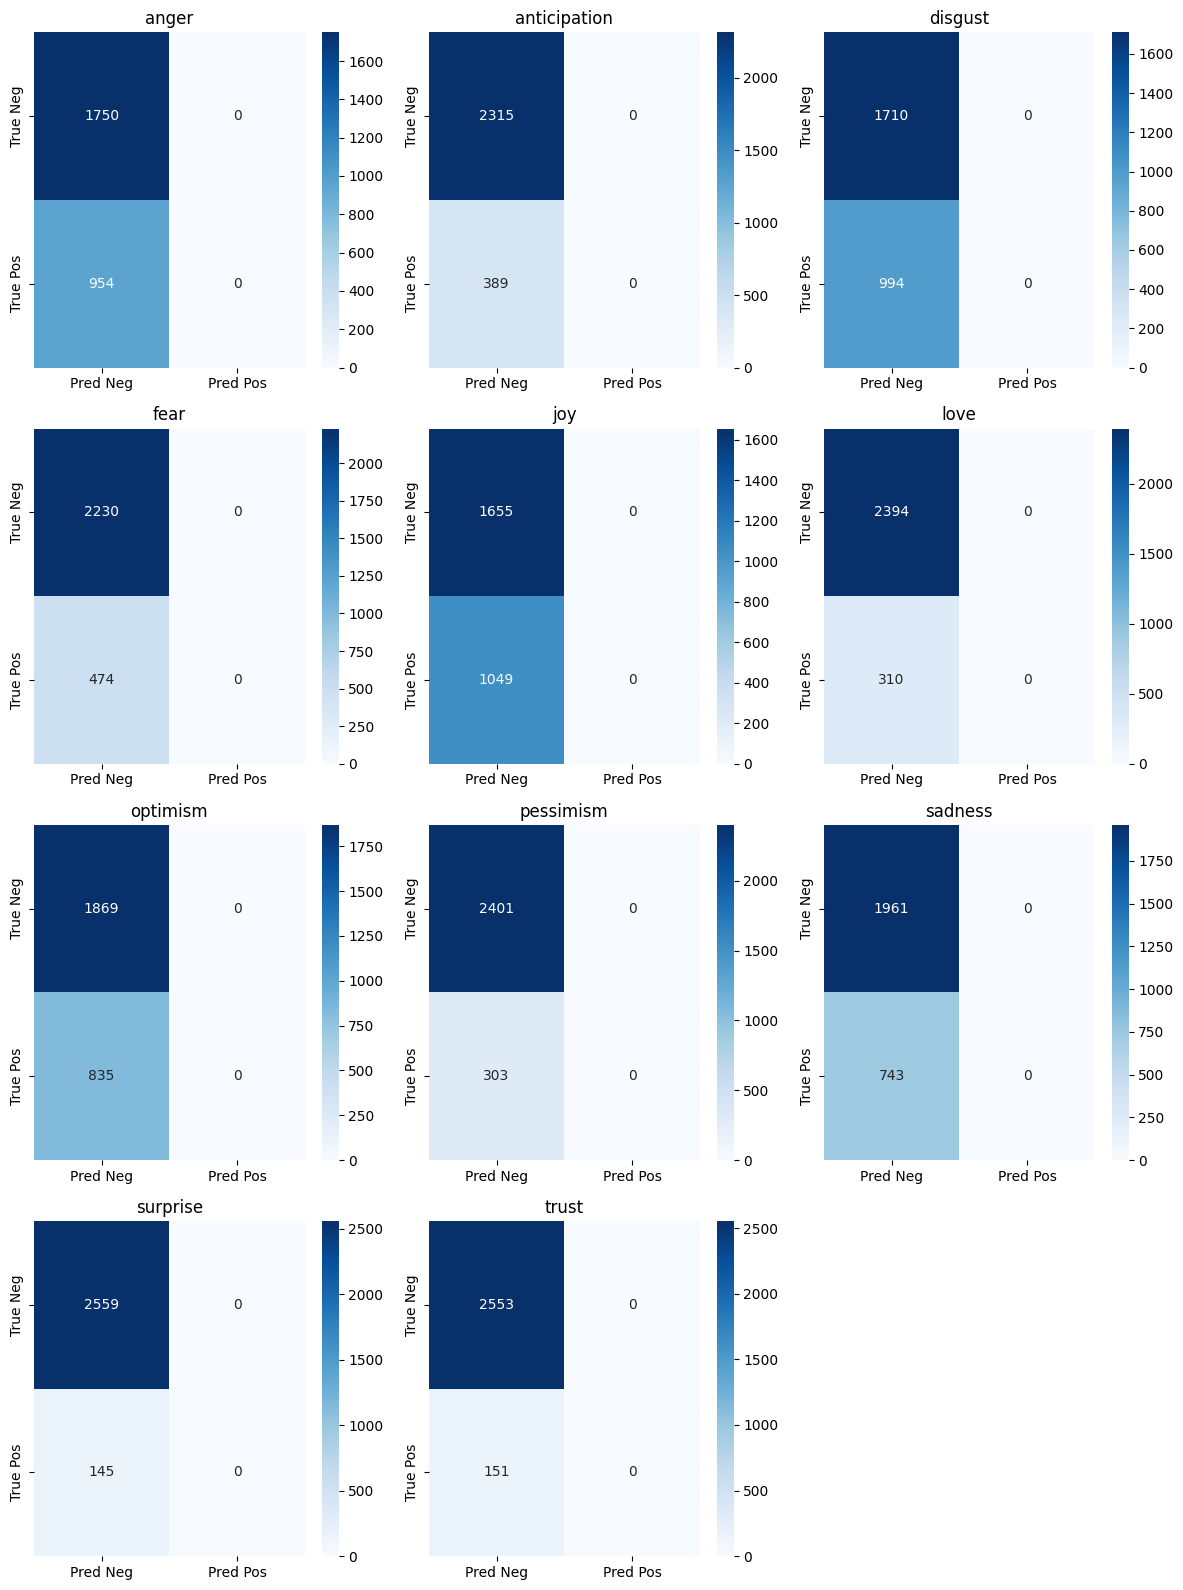

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


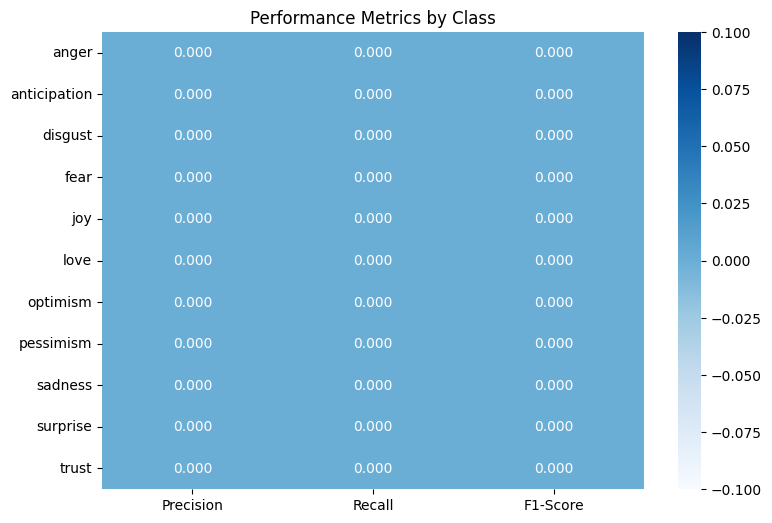

<Figure size 1200x533.333 with 0 Axes>

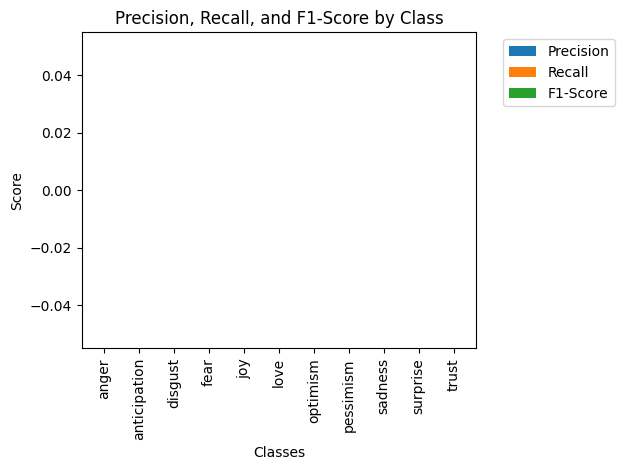

{'macro_avg': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0},
 'per_class': {'Precision': {'anger': 0.0,
   'anticipation': 0.0,
   'disgust': 0.0,
   'fear': 0.0,
   'joy': 0.0,
   'love': 0.0,
   'optimism': 0.0,
   'pessimism': 0.0,
   'sadness': 0.0,
   'surprise': 0.0,
   'trust': 0.0},
  'Recall': {'anger': 0.0,
   'anticipation': 0.0,
   'disgust': 0.0,
   'fear': 0.0,
   'joy': 0.0,
   'love': 0.0,
   'optimism': 0.0,
   'pessimism': 0.0,
   'sadness': 0.0,
   'surprise': 0.0,
   'trust': 0.0},
  'F1-Score': {'anger': 0.0,
   'anticipation': 0.0,
   'disgust': 0.0,
   'fear': 0.0,
   'joy': 0.0,
   'love': 0.0,
   'optimism': 0.0,
   'pessimism': 0.0,
   'sadness': 0.0,
   'surprise': 0.0,
   'trust': 0.0}}}

In [ ]:
multilabel_evaluation(y_true=valid_labels_binary, y_pred=valid_predictions_binary, class_names=class_names, figsize=(12, 8))

#**7. Performance on Test Set** </font>
For test set evaluation, we will perfrom following steps:



In [ ]:
test_split = test_set
test_split

Dataset({
    features: ['text', 'label'],
    num_rows: 3259
})

In [ ]:
test_split = test_split.map(filter_function, desc="Processing dataset")

Processing dataset:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [ ]:
testset_filtered = test_split.filter(lambda x: x['keep']).remove_columns(['keep'])

Filter:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [ ]:
testset_filtered

Dataset({
    features: ['text', 'label'],
    num_rows: 3259
})

In [ ]:
free_gpu_memory()

GPU memory has been freed.


In [ ]:
test_inference_results = execute_inference_pipeline(seed = 42,
              dataset=testset_filtered,
              model=model,
              tokenizer=tokenizer,
              per_device_batch_size=40,
              prompt_template=prompt_template,
              input_field=input_field,
              output_field=output_field,
              output_delimiter=output_delimiter,
              save_dir=model_folder,
              save_file_name = 'test_complete_generations')

Model device for inference: cuda:0


Generating responses: 100%|██████████| 82/82 [01:13<00:00,  1.12it/s]

Saved inference_results to: /content/drive/MyDrive/NLP/models/llama_qlora_lmh/test_complete_generations.json


In [ ]:
file_name = model_folder/'test_complete_generations.json'
with open(file_name, 'r') as f:
    test_inference_results = json.load(f)

In [ ]:
test_extracted_outputs = [
    parse_generated_segment(result['generated_output'], output_delimiter)
    for result in test_inference_results
]

# Clean and convert predictions and ground truth
test_predictions = [
    clean_and_split_labels(extracted_output, class_names)
    for extracted_output in test_extracted_outputs
]

mlb = MultiLabelBinarizer(classes=class_names)
mlb.fit(class_names)

test_predictions_binary = mlb.transform(test_predictions)

print("Sample of predictions:", test_predictions[:4])
print("\nBinary format:")
print("Predictions shape:", test_predictions_binary.shape)

Sample of predictions: [[], [], [], []]

Binary format:
Predictions shape: (3259, 11)


<font color = 'indianred'> *Confusion Matrix*</font>

In [ ]:
test_predictions_binary

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
wandb.finish()

eval/loss,█▆▄▃▃▃▂▂▂▁▁▁▁▁▁
eval/runtime,█▃▄▄▁▄▂▄▄▅▂▃▄▄▄
eval/samples_per_second,▁▆▅▄█▅▇▅▅▄▇▆▅▅▅
eval/steps_per_second,▁▆▅▄█▅▇▅▅▄▇▆▅▅▅
train/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
train/grad_norm,█▂▂▃▂▁▃▁▂▂▂▂▂▂▁
train/learning_rate,██▇▆▆▆▅▄▄▃▃▂▂▂▁
train/loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁
valid_f1_macro,▁
eval/loss,0.3242


# <Font color = 'indianred'> **8. Model Inference**



In [ ]:
result = pd.DataFrame(test_predictions_binary, columns=class_names)
result

,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3254,0,0,0,0,0,0,0,0,0,0,0
3255,0,0,0,0,0,0,0,0,0,0,0
3256,0,0,0,0,0,0,0,0,0,0,0
3257,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
try:
    result.insert(0, 'ID', test_data['ID'])
except ValueError:
    pass

In [ ]:
result

,ID,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-01559,0,0,0,0,0,0,0,0,0,0,0
1,2018-03739,0,0,0,0,0,0,0,0,0,0,0
2,2018-00385,0,0,0,0,0,0,0,0,0,0,0
3,2018-03001,0,0,0,0,0,0,0,0,0,0,0
4,2018-01988,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3254,2018-03848,0,0,0,0,0,0,0,0,0,0,0
3255,2018-00416,0,0,0,0,0,0,0,0,0,0,0
3256,2018-03717,0,0,0,0,0,0,0,0,0,0,0
3257,2018-03504,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
from google.colab import files

# Save DataFrame to CSV
csv_filename = 'result_Qlora_meta_llama_base_multilabell_class.csv'
result.to_csv(csv_filename,index=False)
files.download(csv_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>